<span style="font-family:calibri; font-weight:bold; font-size:1.5em; line-height:1.3em;">
Summary
    
* [Functions](#functions)
    
* [Dynamics Analysis of Goodness-of-fit of Power Laws to Log-returns](#dynamic)
    
    
* [Supplementary Figures S2 and S3](#s2_s3)
    
* [Figure 1](#fig1)
    
* [Supplementary Figure S1](#s1)
    
* [Supplementary Figure S5](#s4)
    
</span>

In [1]:
import numpy as np
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import tqdm
import string

import scipy.stats
import powerlaw

#extender o notebook
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container {width:99.5% !important;} </style>"))

/tmp/ipykernel_61183/1311817341.py:15: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# <span style="font-family:calibri; font-weight:bold; font-size:1.4em;">Functions</span><a class="anchor" id="functions"></a>

In [2]:
#Overall definitions of a figure style we use.
def stdfigsize(scale=1.0, nrows=1, ncols=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.

    Parameters
    ----------
    scale: float
           Relationship between the size of the labels 
           and the size of the plot itself. Scales < 1
           favor the labels and vice-versa. 
           (Default: 1.)
    nrows: int
           Number of rows. (Default: 1)
    ncols: int
           Number of columns. (Default: 1)
    ratio: float
           Ratio between the horizontal and vertical 
           lengths of a figure. Default: 1.3.
    ----------
    Returns (7*ratio*scale*nrows, 7.*scale*ncols).
    """
    return((7*ratio*scale*ncols, 7.*scale*nrows))


sns.set_style("white")
sns.set_style({"xtick.direction": "out", "ytick.direction": "out"})

rcparams = {
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica'], #Helvetica must be installed for this to work
    'axes.labelsize': 28,
    'axes.titlesize': 28,
    'legend.fontsize': 20,
    'ytick.right': 'off',
    'xtick.top': 'off',
    'ytick.left': 'on',
    'xtick.bottom': 'on',
    'xtick.labelsize': '25',
    'ytick.labelsize': '25',
    'axes.linewidth': 2.5,
    'xtick.major.width': 1.8,
    'xtick.minor.width': 1.8,
    'xtick.major.size': 14,
    'xtick.minor.size': 7,
    'xtick.major.pad': 10,
    'xtick.minor.pad': 10,
    'ytick.major.width': 1.8,
    'ytick.minor.width': 1.8,
    'ytick.major.size': 14,
    'ytick.minor.size': 7,
    'ytick.major.pad': 10,
    'ytick.minor.pad': 10,
    'axes.labelpad': 15,
    'axes.titlepad': 15,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'figure.figsize': stdfigsize(),
    'lines.linewidth': 3
}
mpl.rcParams.update(rcparams)

In [3]:
def parallel_REJECT_powerlaw(log_returns, threshold=.1, p_value=True, repetitions=1000, more_info=True, Clauset=False):
    """
    Performs a goodness-of-fit test for a power-law hypothesis
    after the works of Clauset et al., Power-Law Distributions in
    Empirical Data, SIAM Review (2009) and Preis et al., Switching
    processes in financial markets, PNAS (2011).
    
    Parameters
    ----------
    log_returns: pd.Series
                 Series of log-returns of a financial asset.
    threshold: float
               Rejection limit of the powerlaw hypothesis.
               If p_value <= threshold we reject the 
               powerlaw hypothesis. (Default: 0.1).
    p_value : bool 
              Whether to return the p_value or not.
              (Default: True).
    repetitions: int 
                 Number of synthetic datasets generated to 
                 calculate the Kolmogorov-Smirnov distance 
                 and estimate the p-value for goodness-of-fit 
                 of a power law to the log-returns. If None, 
                 the number of repetitions will be either 
                 625 or 5000, depending on the precision 
                 needed for comparison. (Default: 1000).
    more_info: bool
               Whether to return more information on the 
               hypothesis testing procedure, such as the 
               Kolmogorov-Smirnov distance, the power-law
               exponent alpha and the xmin, the number of tail 
               observations and whether invalid fits were
               obtained during the testing.
    Clauset: bool
             Whether to generate samples using the bootstrapping approach
             of Clauset et al. or that of Preis et al. (Default: True)
    ----------
    Returns a boolean indicating whether to accept or reject the 
    powerlaw hypothesis based on the threshold parameter and possibly
    much more data related to the fitting process.
    
    P.S.: in case more_info=True this function returns a list with 11 entries, 
          those being the KS distance, p-value, the boolean of rejection, the 
          number of synthetic samples, the alpha, the sigma (error of alpha), 
          the xmin, the largest observed returns, the number of tail observations,
          the length of the return series, and whether there are invalid fits of not.
    """
    def no_parameter_FIT(sample):
        """
        Takes a sample of randomly generated power-law numbers 
        and fits them to a power-law distribution following the
        approach of Preis et al.
        
        Parameters
        ----------
        sample: tuple
                Sample of powerlaw random numbers and
                their respective xmin, e.g., 
                (samples_array, xmin)
        ----------
        Returns the Kolmogorov-Smirnov distance and a boolean 
        noise flag when "no valid fits are found".           
        """
        returns, xmin_  = sample
        fitted          = powerlaw.Fit(returns, xmin=xmin_, verbose=False)

        return fitted.D, bool(fitted.noise_flag)
    
    def no_parameter_FIT_Clauset(sample):
        """
        Takes a sample of randomly generated power-law numbers 
        and fits them to a power-law distribution following the 
        approach of Clauset et al.
        
        Parameters
        ----------
        sample: array
                Samples of power-law distributed random numbers.       
        ----------
        Returns the Kolmogorov-Smirnov distance and a boolean 
        noise flag when "no valid fits are found".
                    
        """
        returns  = sample
        fitted   = powerlaw.Fit(returns, verbose=False)

        return fitted.D, bool(fitted.noise_flag)
    ########################
    
    fit = powerlaw.Fit(log_returns, verbose=False)
    
    if not bool(fit.noise_flag): #if we cannot fit we abort
        if repetitions==None:
            if str(fit.D)[0]=='0': # first algarism is zero
                if str(fit.D)[2:][0]!='0': #first digit is different from zero
                    repetitions=625 #0.02
                else: #first digit is zero
                    repetitions=5000 #.007
            else:
                repetitions=100    
        else: pass

        if Clauset==True:
            sample_size  = len(log_returns)
            tail_size    = int(fit.n_tail)
            syn_samples  = []

            for _ in range(repetitions):
                #p is probability of being one; in our case, probability of being a tail observation
                tail_or_not  = scipy.stats.bernoulli.rvs(p=round(tail_size/sample_size, 4), size=sample_size).sum()
                body_samples = log_returns[log_returns<fit.xmin].iloc[
                                           np.random.randint(0, sample_size-tail_size, size=sample_size-tail_or_not)] #bootstrapping synthetic samples from the empirical samples
                tail_samples = fit.power_law.generate_random(n=tail_or_not)

                syn_samples.append(np.concatenate((body_samples, tail_samples)))

        else:
            syn_samples  = [(fit.power_law.generate_random(n=int(fit.n_tail)), fit.xmin) for _ in range(repetitions)]

        #hard work
        if Clauset==False:
            samples_info = np.asarray([no_parameter_FIT(sample_) for sample_ in syn_samples])
        else:
            samples_info = np.asarray([no_parameter_FIT_Clauset(sample_) for sample_ in syn_samples])

        KS_distances = samples_info[::,0]
        invalid_fits = samples_info[::,1]
    
        PVALUE       = np.sum(KS_distances>fit.D)/repetitions #to differentiate from the p_value parameter

        if p_value==False:
            return PVALUE<=threshold
        elif p_value==True and more_info==False:
            return PVALUE, PVALUE<=threshold
        else:
            return [round(fit.D, 4), round(PVALUE, 4), PVALUE<=threshold, repetitions, round(fit.alpha, 5), 
                    round(fit.sigma, 5), fit.xmin, max(log_returns), int(fit.n_tail), log_returns.__len__(), 
                    bool(sum(invalid_fits))]
    
    else:
        if p_value==False:
            return None
        elif p_value==True and more_info==False:
            return None, None
        else:
            return ["Could not fit"]+[None]*10

In [4]:
def POWERLAW_goodness_of_fit(log_returns, label=["Bitcoin", 'btc', 'bitcoin'], days_saw=200, days_to_see=7, Clauset=False):
    """
    Performs goodness-of-fit tests for power-law hypotheses
    using an expanding time window.
    
    Parameters
    ----------
    log_returns: pd.Series
                 Series of log-returns of a financial asset.
    label: list
           Name, ticker and slug of the asset associated to 
           the log-return series.
    days_saw: int
              Number of days passively observed before fitting the positive 
              and negative return distributions for the first time.
    days_to_see: int
                 Size of the steps taking when expanding the time window to
                 future observations of the series.
    Clauset: bool
             Whether to generate samples using the bootstrapping approach
             of Clauset et al. or that of Preis et al. (Default: False).
             (See the parallel_REJECT_powerlaw() for details on papers).
    ----------
    Returns a list of lists ready to be fed to the pd.Dataframe function.
    
    Returned data: asset name, ticker, slug, series length, KS distance, p-value, 
                   reject_powerlaw, repetitions, alpha, alpha_ste, xmin, xmax, 
                   number of observations in the tail, length of returns, 
                   invalid_fits, positive_tail.
                   
    The returned data concerns both the positive and negative tails.
    """
    days_TO_see           = days_to_see
    returns_POS_week_info = []
    returns_NEG_week_info = []
    
    try:
        _    = len(label)
        coin_= label
    except:
        coin_= ''
    
    full_returns = log_returns
    time_windows = (len(full_returns)-days_saw)//days_TO_see
    for i in range(time_windows+2): 
        returns       = full_returns[:days_saw+days_TO_see*i].copy()
        returns_PLUS  = returns[returns>0]
        returns_MINUS = np.absolute(returns[returns<0])
        
        try:
            returns_POS_week_info.append([*label, returns.index[-1], len(returns), *parallel_REJECT_powerlaw(returns_PLUS, p_value=True, more_info=True, Clauset=Clauset), True])
            returns_NEG_week_info.append([*label, returns.index[-1], len(returns), *parallel_REJECT_powerlaw(returns_MINUS, p_value=True, more_info=True, Clauset=Clauset), False])

        except:
            returns_POS_week_info.append([*label, returns.index[-1], len(returns), *[None]*11, True])
            returns_NEG_week_info.append([*label, returns.index[-1], len(returns), *[None]*11, False])
            
    return returns_POS_week_info, returns_NEG_week_info

In [5]:
def rejection_fraction_FUNCTION(groupy_):
    """
    Calculates the fraction of time windows
    in which the power-law hipothesis for 
    describing the tails of log-return distributions
    is rejected.
    
    Parameters
    ----------
    groupy_: pd.DataFrameGroubpy
             DataFrame with powerlaw testing data.
    ----------
    Returns a tuple with the rejection rates for the 
    negative and positive tails of a cryptoasset.
    """
    NEG_groupy_ = groupy_[groupy_['positive_tail']==False]
    POS_groupy_ = groupy_[groupy_['positive_tail']==True]
    
    if NEG_groupy_.__len__()>0:
        NEG_rej_powerlaw = NEG_groupy_['reject_powerlaw'].sum()/NEG_groupy_.__len__()
    else:
        NEG_rej_powerlaw = np.nan
        
    if POS_groupy_.__len__()>0:
        POS_rej_powerlaw = POS_groupy_['reject_powerlaw'].sum()/POS_groupy_.__len__()
    else:
        POS_rej_powerlaw = np.nan
    
    return NEG_rej_powerlaw, POS_rej_powerlaw

In [6]:
def scipy_kde(data, nbins=150, log=False, symmetrical=False, bw_method=None):
    """
    Evaluates the kde from a np.array via scipy.stats.gaussian_kde.

    Parameters
    ----------
    data: array 
          Array of data for which one 
          wishes to estimate a distribution.
    nbins: int
           Number of bins used in the estimation process.
           (Default: 150).
    log: bool
         True for logspaced bins. (Default: False).
    symmetrical: bool
                 True for symmetrical bin interval.
                 (Default: False).
    bw_method: bandwidth method. (Default: None).
    ----------
    Returns a list containing two arrays, in the 
    form [bins, kde].
    """
    if log:
        if symmetrical:
            maxdata = max(np.abs(np.min(data)), np.abs(np.max(data)))
            bins = np.logspace(-maxdata, maxdata, nbins)
        else:
            bins = np.logspace(np.log10(np.min(data)), np.log10(np.max(data)), nbins)
    else:
        if symmetrical:
            maxdata = max(np.abs(np.min(data)), np.abs(np.max(data)))
            bins = np.linspace(-maxdata, maxdata, nbins)
        else:
            bins = np.linspace(np.min(data), np.max(data), nbins)
            
    gkde = scipy.stats.gaussian_kde(data, bw_method)
    
    return (np.transpose([bins, gkde(bins)]))

In [7]:
def KDE_function(data, loc='median', nbins=1000, drange=False, lowpercent=2.5, highpercent=97.5):
    """
    Fits a Gaussian kernel to data to estimate 
    a probability density function. (Basically a 
    wrapper to scipy.stats.gaussian_kde().)
    
    Parameters
    ----------
    data: array 
          A 1d iterable object containing floating numbers
          for which one wishes to estimate a distribution.
    loc: str
         Either 'median' or 'mean'. (Default: 'median').
    nbins: int
          Number of bins used to estimate the kernel.         
          (Default: 1000)
    drange: bool
            Whether to return the 2.5 (lowpercent) and 
            97.5 (highpercent) percentiles (that is, a 
            95% data window). (Default: False)
    lowpercent: float
                Lowest specified percentile of data.
                (Default: 2.5%).
    highpercent: float
                 Highest specified percentile of data.
                 (Default: 97.5%).
    ----------
    Returns a tuple of arrays containing x, pdf(x), 
    xmedian, ymedian and, possibly, the two percentiles
    of the data.
    """
    if loc=='median':
        if drange==False:
            x, y       = scipy_kde(data, nbins=nbins).T
            median_    = np.median(data)
            idx_median = np.abs(x-median_).argmin()
            
            return x, y, median_, y[idx_median]

        else:
            x, y       = scipy_kde(data, nbins=nbins).T
            median_    = np.median(data)
            min_       = np.percentile(data, lowpercent, interpolation='nearest')
            max_       = np.percentile(data, highpercent, interpolation='nearest')
            idx_median = np.abs(x-median_).argmin()

            return x, y, median_, y[idx_median], min_, max_
        
    else: #'mean'
        if drange==False:
            x, y     = scipy_kde(data, nbins=nbins).T
            mean_    = np.mean(data)
            idx_mean = np.abs(x-mean_).argmin()
            
            return x, y, mean_, y[idx_mean]

        else:
            x, y       = scipy_kde(data, nbins=nbins).T
            mean_      = np.mean(data)
            idx_mean   = np.abs(x-mean_).argmin()
            min_       = np.percentile(data, lowpercent, interpolation='nearest')
            max_       = np.percentile(data, highpercent, interpolation='nearest')

            return x, y, mean_, y[idx_mean], min_, max_

In [8]:
def cdf(data, nbins=15, log=False, surv=True):
    """
    Estimates the survival distribution from an 
    array.

    Parameters
    ----------
    data: array
          An array containg data from which one
          wishes to estimate the CDF or CCDF.
    nbins: int 
           Number of bins used to estimate the 
           distribution. (Default: 15)
    log: bool
         True for log-spaced bins. (Default: False).
    surv: bool
          False for cumulative distribution function and
          True for survival (CCDF). (Default: True).
    ----------
    Returns [bins,pdf].
    """
    size = len(data)
    
    if log:
        bins = np.logspace(np.log10(np.min(data)), np.log10(np.max(data)), nbins)
    else:
        bins = np.linspace(np.min(data), np.max(data),nbins)        
        
    densities = np.array([len(data[data>=binvalue])/size for binvalue in bins])
    
    if not surv:
        densities = 1 - densities
        
    return(np.transpose([bins, densities]))

In [9]:
def medABSdev(data_):
    """
    Calculates the median absolute deviation
    (in a robust manner, avoiding nans) using
    numpy.
    """
    return np.nanmedian(np.abs(data_ - np.nanmedian(data_)))

In [10]:
def powerlaw_percentile(groupby_, percentile=.9, percentual=True):
    """
    Calculates the (percentual change) value 
    corresponding to the specified percentile 
    relative to parameters of the power law.

    Parameters
    ----------
    groupy_: pd.DataFrameGroubpy
             DataFrame with powerlaw testing data.
    percentile: float
                A percentile between 0 and 1.
    percentual: bool
                Whether to return percentiles as 
                floats or percentages.
    ----------
    Returns the value of the specified percentile. 
    """
    alpha, xmin = groupby_['alpha'], groupby_['xmin']
    x           = xmin*(1-percentile)**(1/(1-alpha))

    if percentual:
        return 100*(np.exp(x)-1) #transforms to percentages
    else:
        return x

In [11]:
def ratio_of_EXTREMA(groupby_, percentile=.9, percentual=True):
    """
    For a chosen percentile calculates the ration
    between the positive and negative percentile
    values.
    
    Parameters
    ----------
    groupy_: pd.DataFrameGroubpy
             DataFrame with powerlaw testing data.
    percentile: float
                A percentile between 0 and 1.
    percentual: bool
                Whether to return percentiles as 
                floats or percentages.
    ----------
    Returns a fraction representing how frequently, 
    for a chosen percentile, the percentile of the 
    positive tail is larger than the same percentile
    of the negative tail.
    
    P.S: the ratio is calculated only for weeks in which 
         both tails succesfully fit a power law and fail
         to reject the power-law hypothesis.
    """
    pos   = groupby_[groupby_['positive_tail']==True]
    NEG   = groupby_[groupby_['positive_tail']==False]
    mask  = ~(pos['reject_powerlaw'] | NEG['reject_powerlaw']).values
    if not sum(mask)==0:
        pos   = pos[mask][['alpha', 'xmin']].apply(powerlaw_percentile, percentile=percentile, percentual=percentual, axis=1).values
        NEG   = NEG[mask][['alpha', 'xmin']].apply(powerlaw_percentile, percentile=percentile, percentual=percentual, axis=1).values        
        ratio = pos/NEG
        
        return sum(ratio>1)/ratio.__len__()    
    else: 
        return np.nan

In [12]:
def get_FIRST_date(groupby_):
    """
    Gets the first date of a series.
    
    Parameters
    ----------
    groupby_: pd.DataFrameGroubpy 
              DataFrame with log-return series data.
    ----------
    Returns the first date (with data)
    for a cryptocurrency.
    """
    return groupby_.Date[0]

In [13]:
def load_obj(name):
    '''
    Loads a pickle file 'name.pkl'

    input:
        * name - str, filename
    output:
        * file - obj, object stored in file
    '''
    with open(name, 'rb') as f:
        return pickle.load(f)

# <span style="font-family:calibri; font-weight:bold; font-size:1.4em;">Dynamic Analysis of Goodness-of-fit of Power Laws to Log-returns </span><a class="anchor" id="dynamic"></a>

In [14]:
df_all_data_clean = pd.read_pickle('data/df_all_data_clean.pkl')

In [37]:
#Heavy work!

all_goodness_clean = []
days_saw_        = 100
days_to_see_     = 7
counter          = 1
    
# # Uncomment to run. ~80h to run in a 5th generation i5. Next cell contain this data already run.  
for slug_, crypto_ in df_all_data_clean.loc['shiba-inu'].groupby('slug', sort=False): 
    crypto_        = crypto_.reset_index(drop=True).set_index('Date')
    coin_          = crypto_['coin'][0]
    ticker_        = crypto_['ticker'][0]
    rank_          = crypto_['rank'][0]
    crypto_returns = crypto_['logret'].dropna()
    crypto_returns = crypto_returns[~np.isinf(crypto_returns)] #removing possible infinities
    print([f'{counter}/{7111}', coin_, ticker_, slug_])

    returns_POS_week_info, returns_NEG_week_info = POWERLAW_goodness_of_fit(crypto_returns, label=[coin_, ticker_, slug_], days_saw=days_saw_, days_to_see=days_to_see_)
    POS_crypto_extrema_df                        = pd.DataFrame(data=returns_POS_week_info, columns=["coin", "ticker", "slug", "date", "len", "KS", "p_value", "reject_powerlaw", "repetitions", "alpha", "alpha_ste", "xmin", "xmax", "#tail_size", "len_rets", "invalid_fits_pval", "positive_tail"])
    NEG_crypto_extrema_df                        = pd.DataFrame(data=returns_NEG_week_info, columns=["coin", "ticker", "slug", "date", "len", "KS", "p_value", "reject_powerlaw", "repetitions", "alpha", "alpha_ste", "xmin", "xmax", "#tail_size", "len_rets", "invalid_fits_pval", "positive_tail"])


    marketcap_ = [] 
    for i in np.asarray(returns_POS_week_info)[::, 4].astype(int): #getting cap values
        marketcap_.append(crypto_[(~np.isnan(crypto_['logret'])) & (~np.isinf(crypto_['logret']))]['Market Cap'].iloc[i-1])

    POS_crypto_extrema_df['marketcap'] = marketcap_ #crypto_[days_saw_::days_to_see_].append(crypto_.loc[crypto_[days_saw_::days_to_see_].index[-1]:].iloc[[-1]])['Market Cap'].values  
    NEG_crypto_extrema_df['marketcap'] = marketcap_ #crypto_[days_saw_::days_to_see_].append(crypto_.loc[crypto_[days_saw_::days_to_see_].index[-1]:].iloc[[-1]])['Market Cap'].values  

    POS_crypto_extrema_df.insert(0, 'rank', rank_)
    NEG_crypto_extrema_df.insert(0, 'rank', rank_)

    POS_crypto_extrema_df['problems'] = crypto_['problems'][0]
    NEG_crypto_extrema_df['problems'] = crypto_['problems'][0]

    all_goodness_clean += [NEG_crypto_extrema_df, POS_crypto_extrema_df]
    counter                 += 1
    
    clear_output(wait=True)

    all_goodness_clean = pd.concat(all_goodness_clean)
    all_goodness_clean.drop_duplicates(['date', 'len', 'positive_tail'], keep='first', inplace=True)
    all_goodness_clean['reject_powerlaw'] = all_goodness_clean['reject_powerlaw'].fillna(True) #sometimes we cannot fit to data for some reason; in these cases we put np.nan to the 'reject_powerlaw' variable
    all_goodness_clean.set_index('slug', inplace=True)

['1/7111', 'Shiba Inu', 'SHIB', 'shiba-inu']


# <span style="font-family:calibri; font-weight:bold; font-size:1.4em;">Supplementary Figures S2 and S3</span><a class="anchor" id="s2_s3"></a>

In [15]:
all_goodness_clean = pd.read_pickle('data/all_goodness_clean.pkl')

In [16]:
NEG_rate_rej_overall = []
POS_rate_rej_overall = []
slugs_rate_overall   = []

for initial_days in tqdm.tqdm([100, 125,150,175,200, 225, 250, 275, 300]):
    
    short_df = all_goodness_clean[all_goodness_clean['len']>=initial_days].copy(deep=True)
    results  = short_df.groupby('slug', sort=False).apply(rejection_fraction_FUNCTION)

    NEG_rate_rej_powerlaw, POS_rate_rej_powerlaw = np.stack((results.values)).T

    slugs_rate_overall.append(results.index.values)
    NEG_rate_rej_overall.append(NEG_rate_rej_powerlaw)
    POS_rate_rej_overall.append(POS_rate_rej_powerlaw)

100%|█████████████████████████████████████████████| 9/9 [00:34<00:00,  3.88s/it]


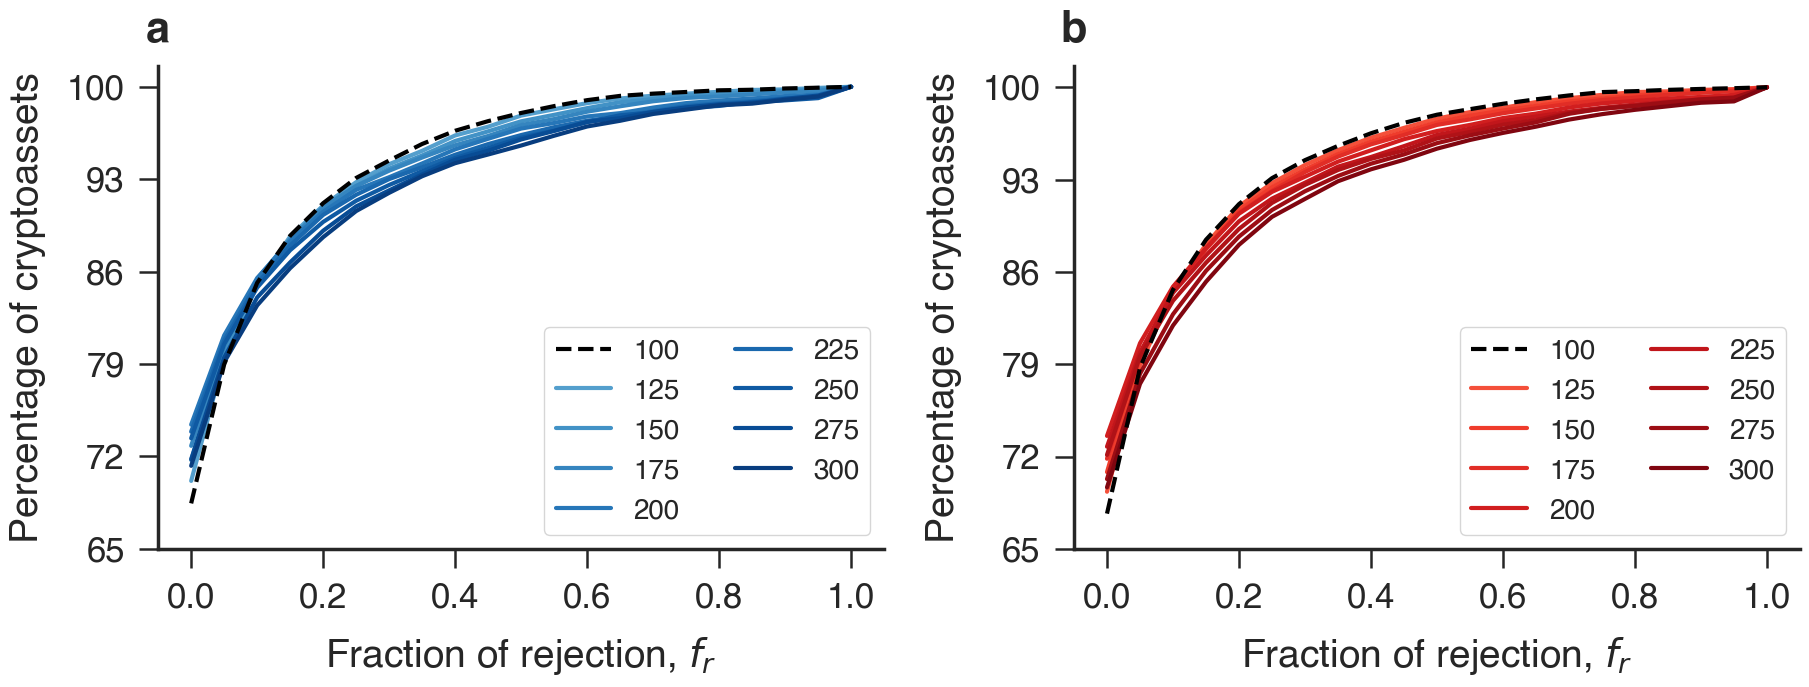

In [17]:
f, ax  = plt.subplots(ncols=2, figsize=stdfigsize(ncols=2))
ax, bx = ax[0], ax[1]
x_     = np.arange(0,1.01,0.05)
ncolors=18
blues  = sns.color_palette('Blues', 2*ncolors)[-(2*ncolors)//2::2]
reds   = sns.color_palette('Reds', 2*ncolors)[-(2*ncolors)//2::2]
lw_    = 3

for pos_all, neg_all, init_days_, bl_, rd_ in zip(NEG_rate_rej_overall, POS_rate_rej_overall, [100,125,150,175,200,225,250,275,300], blues, reds):
    pos_, neg_ = [], []
    for rate_ in x_:
        pos_.append(sum(pos_all<=rate_)/len(pos_all))
        neg_.append(sum(neg_all<=rate_)/len(neg_all))
    pos_ = np.asarray(pos_)
    neg_ = np.asarray(neg_)
    
    if init_days_ in [100]:
        ax.plot(x_, pos_, '--', color='black', linewidth=lw_, label=f'{init_days_}')
        bx.plot(x_, neg_,'--', color='black', linewidth=lw_, label=f'{init_days_}')
    else:
        ax.plot(x_, pos_, '-', color=bl_, linewidth=lw_, label=f'{init_days_}', zorder=-1)
        bx.plot(x_, neg_,'-', color=rd_, linewidth=lw_, label=f'{init_days_}', zorder=-1)        

        
ax.set_ylabel('Percentage of cryptoassets')
ax.set_xlabel('Fraction of rejection, $f_r$')
ax.legend(frameon=True, ncol=2)
ax.set_ylim(.65,)
ax.set_yticks(np.arange(.65,1.01,.07).round(2))
ax.set_yticklabels(np.arange(65,101,7).astype('int'))

bx.set_ylabel('Percentage of cryptoassets')
bx.set_xlabel('Fraction of rejection, $f_r$')
bx.legend(frameon=True, ncol=2)
bx.set_ylim(.65,)
bx.set_yticks(np.arange(.65,1.01,.07).round(2))
bx.set_yticklabels(np.arange(65,101,7).astype('int'))


ax.annotate('a', (0, 1.05), xycoords='axes fraction', weight='bold', ha='center', fontsize=31)
bx.annotate('b', (0, 1.05), xycoords='axes fraction', weight='bold', ha='center', fontsize=31)

f.tight_layout(w_pad=3)
f.savefig('../final-figures/supplementary/figS2.pdf', bbox_inches='tight', dpi=300)

In [18]:
noprob_NEG_rate_rej_overall = []
noprob_POS_rate_rej_overall = []
noprob_slugs_rate_overall   = []

df_noprob                   = all_goodness_clean[all_goodness_clean['problems']==''] #only coins with no nans, inf or sampling problems

for initial_days in tqdm.tqdm([100,125,150,175,200,225,250,275,300]):
    
    short_df = df_noprob[df_noprob['len']>=initial_days].copy()
    results  = short_df.groupby('slug').apply(rejection_fraction_FUNCTION)

    noprob_NEG_rate_rej_powerlaw, noprob_POS_rate_rej_powerlaw = np.stack((results.values)).T

    data_ = np.concatenate((results.index.values.reshape(-1,1), noprob_NEG_rate_rej_powerlaw.reshape(-1,1), noprob_POS_rate_rej_powerlaw.reshape(-1,1)), axis=1)
    df_   = pd.DataFrame(data=data_, columns=['slug', 'neg_rej_rate', 'pos_rej_rate'])

    noprob_slugs_rate_overall.append(df_['slug'].values)
    noprob_NEG_rate_rej_overall.append(df_['neg_rej_rate'].values)
    noprob_POS_rate_rej_overall.append(df_['pos_rej_rate'].values)

100%|█████████████████████████████████████████████| 9/9 [00:29<00:00,  3.24s/it]


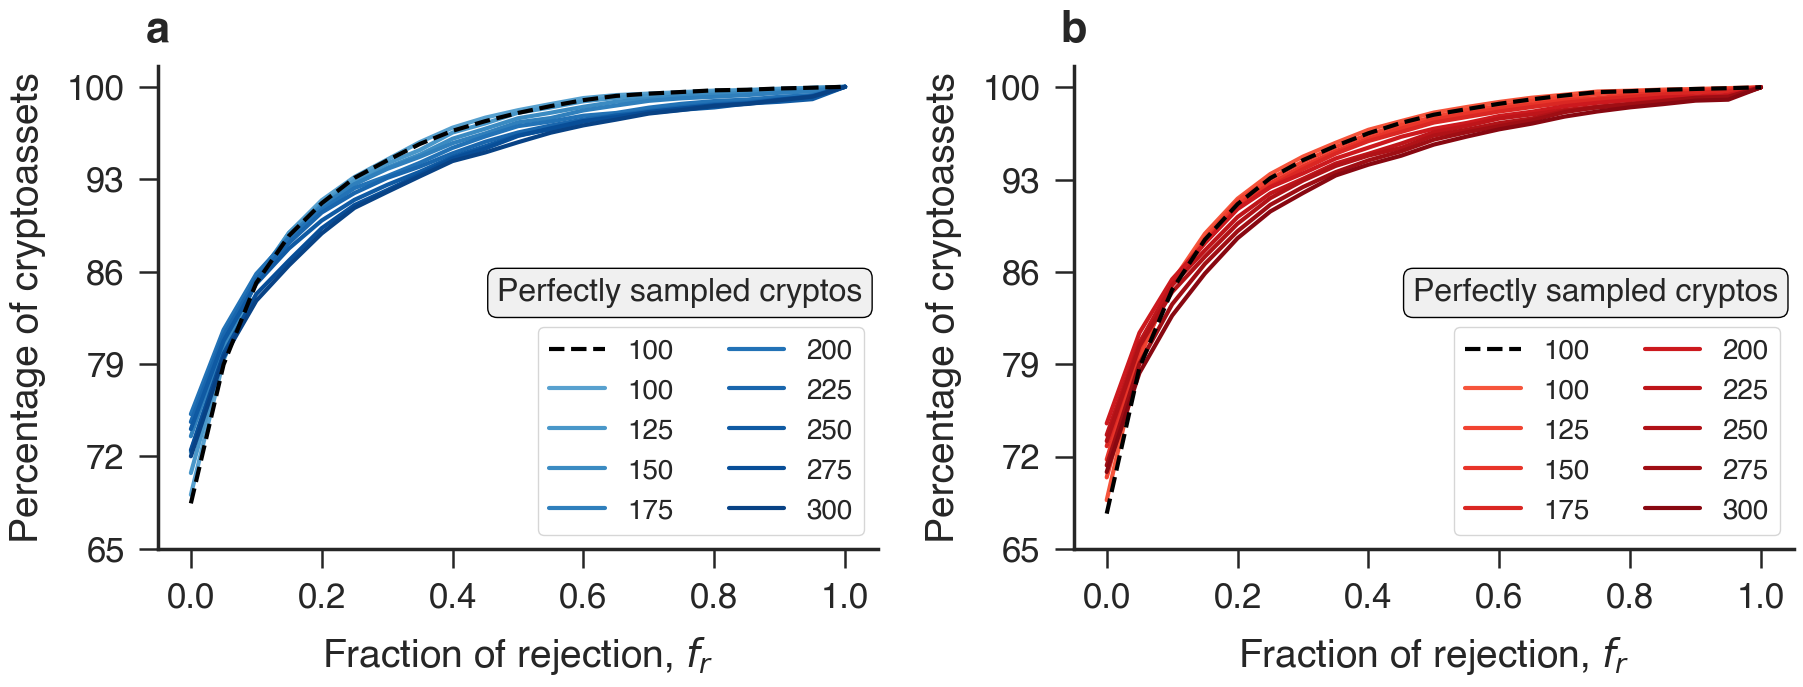

In [19]:
f, ax  = plt.subplots(ncols=2, figsize=stdfigsize(ncols=2))
ax, bx = ax[0], ax[1]
x_     = np.arange(0,1.01,0.05)
ncolors=21
blues  = sns.color_palette('Blues', 2*ncolors)[-(2*ncolors)//2::2]
reds   = sns.color_palette('Reds', 2*ncolors)[-(2*ncolors)//2::2]
lw_    = 3

for pos_all, neg_all, init_days_, bl_, rd_, cnt_ in zip(NEG_rate_rej_overall[:1] + noprob_NEG_rate_rej_overall[0:], POS_rate_rej_overall[:1]+noprob_POS_rate_rej_overall[0:], 
                                                        [100, 100, 125, 150, 175, 200, 225, 250, 275, 300], blues, reds, range(11)):
    pos_, neg_ = [], []
    for rate_ in x_:
        pos_.append(sum(pos_all<=rate_)/len(pos_all))
        neg_.append(sum(neg_all<=rate_)/len(neg_all))
    pos_ = np.asarray(pos_)
    neg_ = np.asarray(neg_)
    
    if cnt_==0:
        ax.plot(x_, pos_, '--', color='black', linewidth=lw_, label=f'{init_days_}')
        bx.plot(x_, neg_,'--', color='black', linewidth=lw_, label=f'{init_days_}')
    else:
        ax.plot(x_, pos_, '-', color=bl_, linewidth=lw_, label=f'{init_days_}', zorder=-1)
        bx.plot(x_, neg_,'-', color=rd_, linewidth=lw_, label=f'{init_days_}', zorder=-1)        
        
ax.set_ylabel('Percentage of cryptoassets')
ax.set_xlabel('Fraction of rejection, $f_r$')
ax.legend(frameon=True, ncol=2)
ax.set_ylim(.65,)
ax.set_yticks(np.arange(.65,1.01,.07).round(2))
ax.set_yticklabels(np.arange(65,101,7).astype('int'))

bx.set_ylabel('Percentage of cryptoassets')
bx.set_xlabel('Fraction of rejection, $f_r$')
bx.legend(frameon=True, ncol=2)
bx.set_ylim(.65,)
bx.set_yticks(np.arange(.65,1.01,.07).round(2))
bx.set_yticklabels(np.arange(65,101,7).astype('int'))


ax.annotate('a', (0, 1.05), xycoords='axes fraction', weight='bold', ha='center', fontsize=31)
bx.annotate('b', (0, 1.05), xycoords='axes fraction', weight='bold', ha='center', fontsize=31)

ax.annotate('Perfectly sampled cryptos', (.725, .53), va='center', ha='center', xycoords='axes fraction',
            fontsize=23,bbox={'boxstyle': 'round', 'fc': '#f0f0f0', 'ec': 'black', 'alpha': 1})
bx.annotate('Perfectly sampled cryptos', (.725, .53), va='center', ha='center', xycoords='axes fraction',
            fontsize=23,bbox={'boxstyle': 'round', 'fc': '#f0f0f0', 'ec': 'black', 'alpha': 1})

f.tight_layout(w_pad=3)
f.savefig('../final-figures/supplementary/figS3.pdf', bbox_inches='tight', dpi=300)

# <span style="font-family:calibri; font-weight:bold; font-size:1.4em;">Figure 1</span><a class="anchor" id="fig1"></a>

Positive median: 4.49764 Negative MAD 0.296 
 Negative median: 2.99411 Negative MAD 0.151


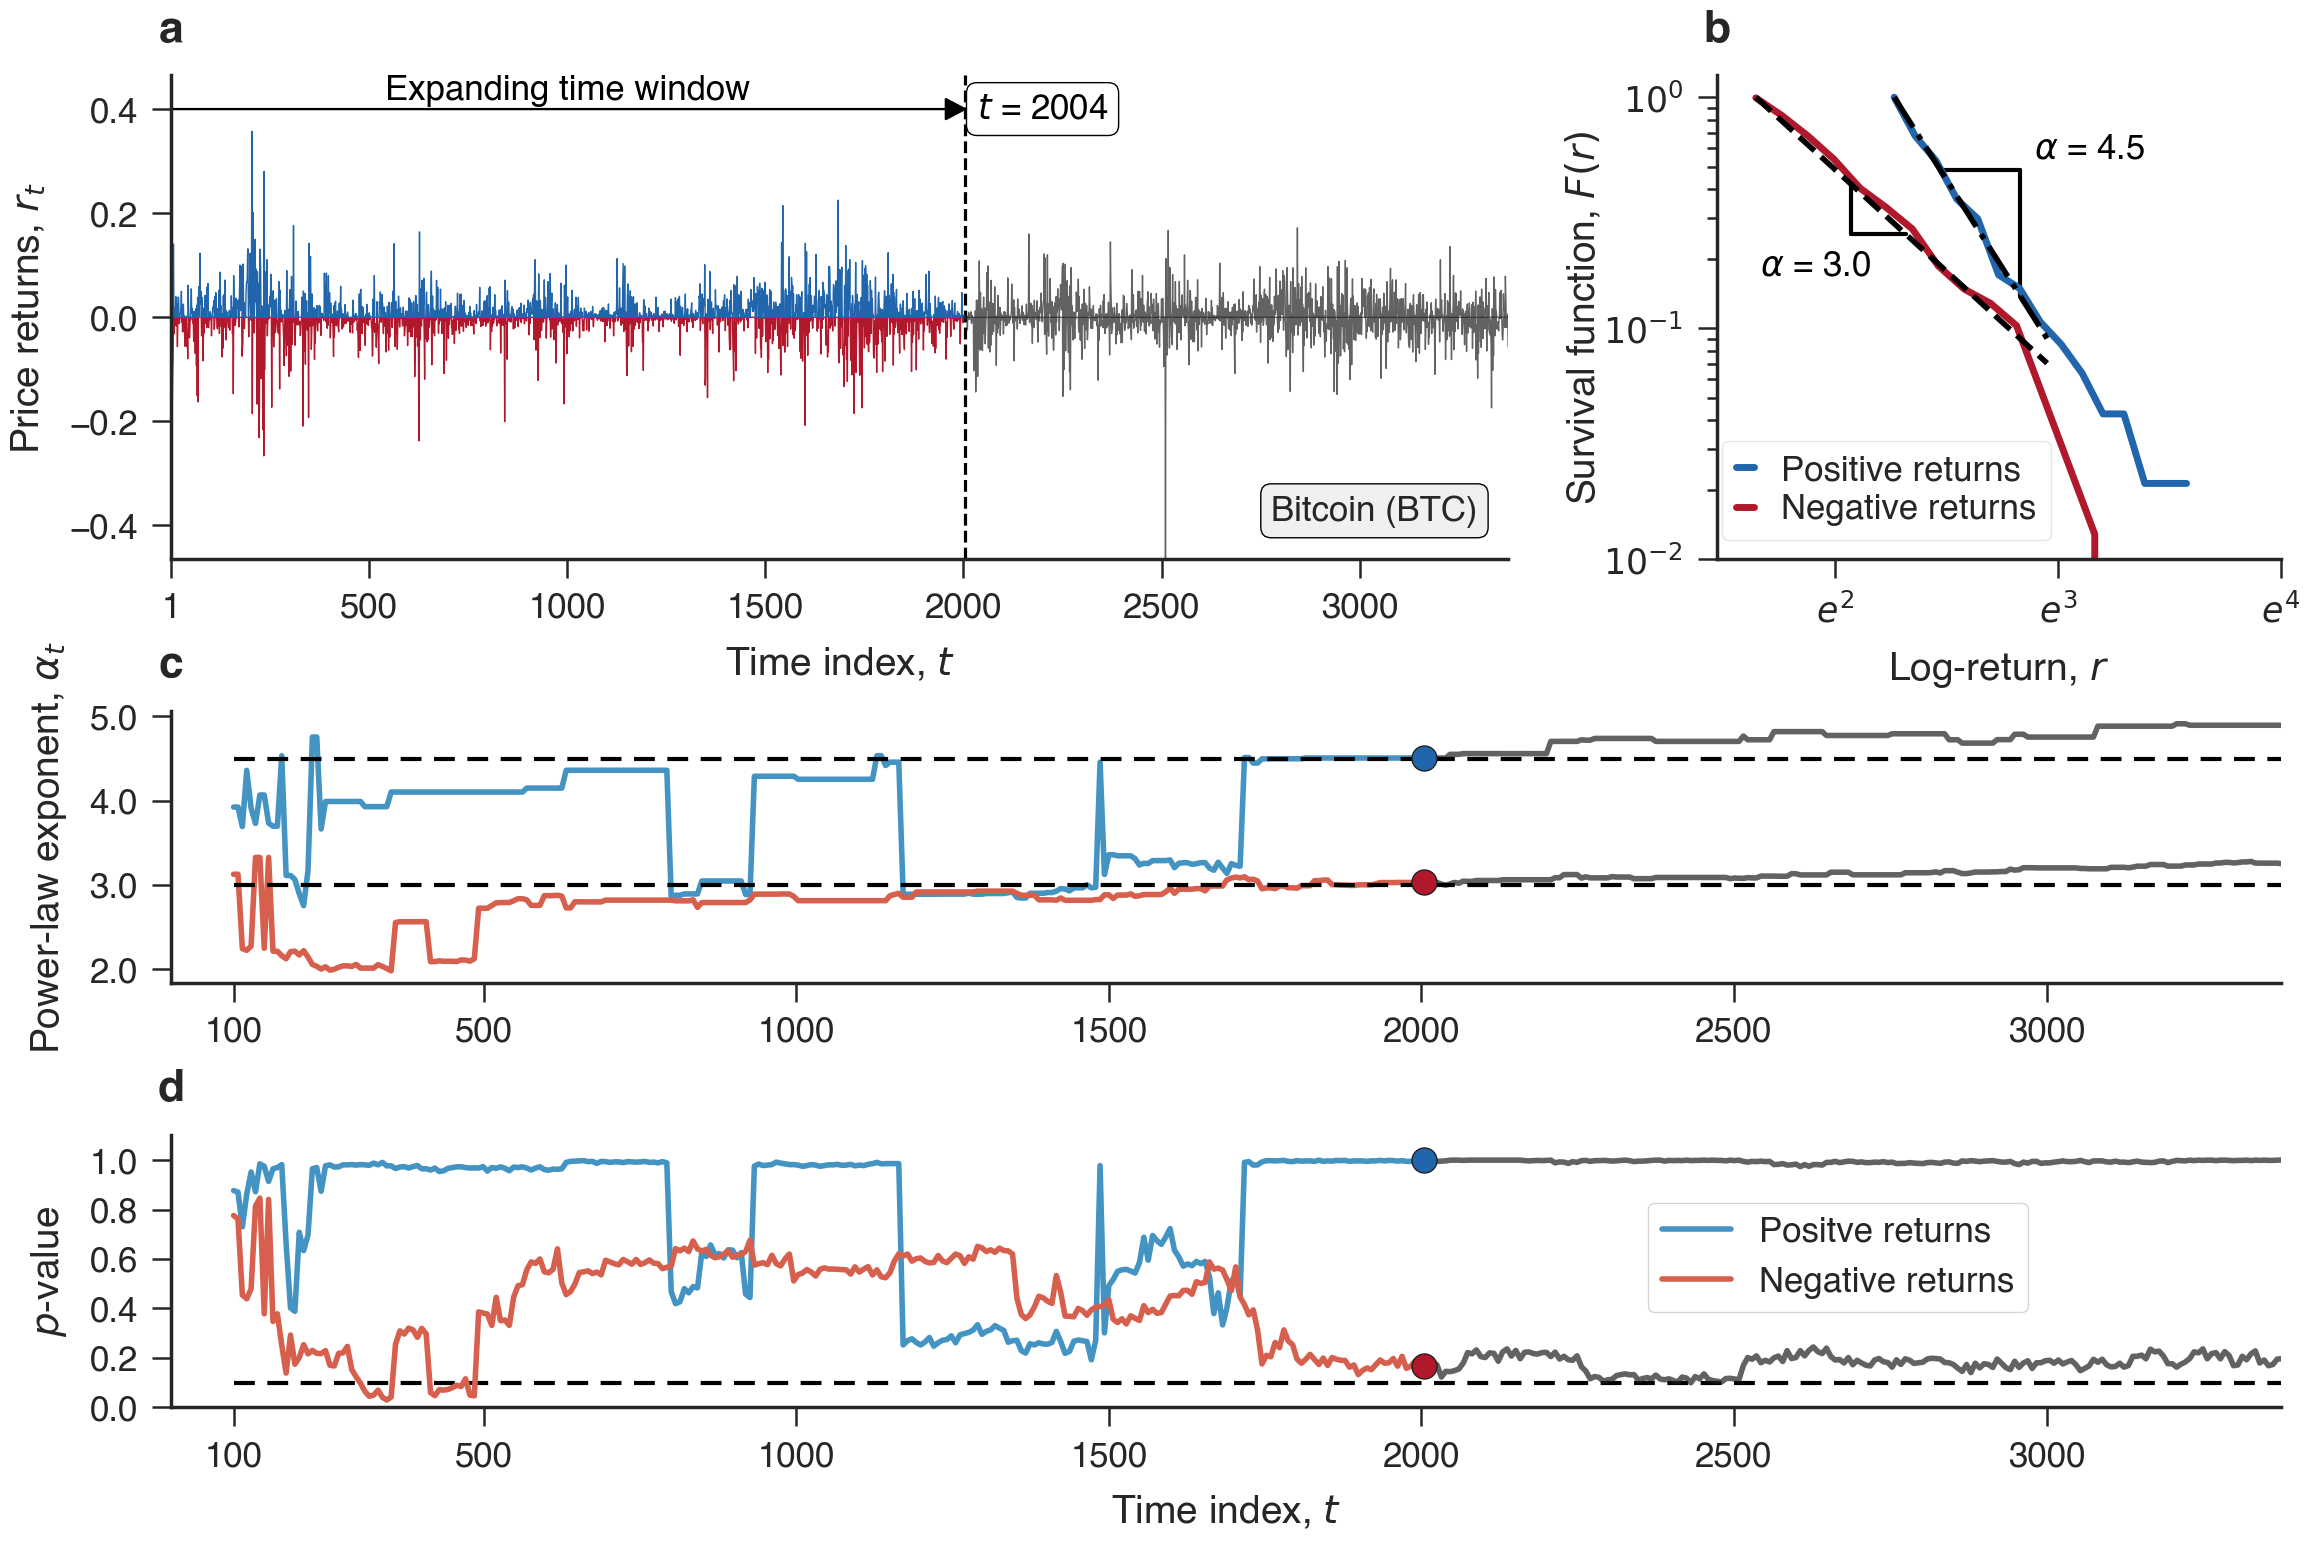

In [22]:
# Functions needed to plot this Figure.
def normalize(x):
    """Normalize array in the [0, 1] interval."""
    return (x - min(x))/(max(x)-min(x))

def fneg(x):
    """Turns negative numbers to zero in an array."""
    if x<0:
        return 0
    else:
        return x
    
def fpos(x):
    """Turns positive numbers to zero in an array."""
    if x>0:
        return 0
    else:
        return x
    
##################################################################################

years = np.arange(0,3375,1).astype('int')[np.isin(df_all_data_clean.loc['bitcoin'].Date.values[1:], ['01-01-2014', '01-01-2015', '01-01-2016', '01-01-2017', '01-01-2018', '01-01-2019', '01-01-2020', '01-01-2021', '01-01-2022'])]
slug  = 'bitcoin'
l_="""
AAAABB
AAAABB
AAAABB
CCCCCC
CCCCCC
DDDDDD
DDDDDD
"""

f    = plt.figure(figsize=stdfigsize(nrows=2.5, ncols=3, ratio=1.3, scale=.85))
ax   = f.subplot_mosaic(mosaic=l_)
ax   = [ax[s] for s in ['A','B','C','D']]

tmax   = 2004
nbins_ = 15
y      = df_all_data_clean.loc[slug]['logret'].dropna()[:]


#PANEL B ################################################################################################
palpha_, pxmin_ = all_goodness_clean.loc[slug][(all_goodness_clean.loc[slug]['len']==tmax)&(all_goodness_clean.loc[slug]['positive_tail']==True)][['alpha', 'xmin']][-1:].values.flatten()
ypret           = y[:tmax]
ypret           = ypret[ypret>=pxmin_]
dist_plus_tail  = cdf(ypret, nbins=nbins_, log=True)
range_          = [ypret.min(), np.e**3/105]
ax[1].loglog(*dist_plus_tail.T, '-', linewidth=5, color='#2166ac', markeredgecolor='#252525', markeredgewidth=2,  label='Positive returns') #full distribution
ax[1].loglog(*np.asarray((range_, [(i/pxmin_)**(1-palpha_) for i in range_])), '-.', linewidth=4, color='black', zorder=2) #tail


xrange_ = [1.23*ypret.min(), 1.76*ypret.min()]
yrange_ = [(i/pxmin_)**(1-palpha_) for i in xrange_]
ax[1].loglog([xrange_[0], xrange_[1]], [yrange_[0], yrange_[0]], color='black', zorder=-5)
ax[1].loglog([xrange_[1], xrange_[1]], [yrange_[0], yrange_[1]], color='black', zorder=-5)
ax[1].annotate(r'$\alpha$ = ' + f'{round(palpha_, 1)}', xy=(xrange_[1]+xrange_[1]/16, yrange_[0]+yrange_[0]/8), fontsize=25, color='black')


ax[1].set_xlabel('Log-return, $r$')
ax[1].set_ylabel('Survival function, $F(r)$', labelpad=0)

xticklabels = [r'$e$',r'$e^2$',r'$e^3$',r'$e^4$'] 
xticks      = np.asarray([np.e,np.e**2,np.e**3,np.e**4])/100. 

nalpha_, nxmin_ = all_goodness_clean.loc[slug][(all_goodness_clean.loc[slug]['len']==tmax)&(all_goodness_clean.loc[slug]['positive_tail']==False)][['alpha', 'xmin']][-1:].values.flatten()
ynret           = y[:tmax]
ynret           = np.abs(ynret[ynret<=-nxmin_])
dist_minus_tail = cdf(ynret, nbins=nbins_,log=True)
range_          = [ynret.min(), np.e**3/105]
ax[1].loglog(*dist_minus_tail.T, '-', linewidth=5, color='#b2182b', markeredgecolor='#252525', markeredgewidth=2,  label='Negative returns') #full distribution
ax[1].loglog(*np.asarray((range_, [(i/nxmin_)**(1-nalpha_) for i in range_])), '--', linewidth=4, color='black', zorder=2) #tail

xrange_ = [1.53*ynret.min(), 1.96*ynret.min()]
yrange_ = [(i/nxmin_)**(1-nalpha_) for i in xrange_]
ax[1].loglog([xrange_[0], xrange_[0]], [yrange_[0], yrange_[1]], color='black', zorder=-5)
ax[1].loglog([xrange_[0], xrange_[1]], [yrange_[1], yrange_[1]], color='black', zorder=-5)
ax[1].annotate(r'$\alpha$ = ' + f'{round(nalpha_, 1)}', xy=(xrange_[0]-xrange_[0]/3, yrange_[1]-yrange_[1]/3), fontsize=25, color='black')

ax[1].set_xticks(xticks)
ax[1].set_xticks([], minor=True)
ax[1].set_xticklabels(xticklabels)
ax[1].set_yticks([0.01, 0.1, 1])
ax[1].set_yticklabels([r'$10^{-2}$', r'$10^{-1}$', r'$10^{0}$'], )
ax[1].legend(loc=(0.01,.04), framealpha=.5, labelspacing=0.2, fontsize=25, handlelength=.5)
ax[1].set_xlim(np.e**2/100/1.7,)



# PANEL A #############################################################################################
numobs= 4000
y     = df_all_data_clean.loc[slug]['logret'].dropna()[:numobs]
x     = np.arange(1, len(y)+1).astype('int')
ypret = y[:numobs]
ynret = y[:numobs]

ax[0].plot(x[:tmax], y.apply(fpos)[:tmax], color='#b2182b', linewidth=1) #negative
ax[0].plot(x[:tmax], y.apply(fneg)[:tmax], color='#2166ac', linewidth=1)

ax[0].plot(x[2000:], y.apply(fpos)[2000:], color='#202020', linewidth=1, alpha=0.7)
ax[0].plot(x[2000:], y.apply(fneg)[2000:], color='#202020', linewidth=1, alpha=0.7)

# ax[0].vlines(years, y.min(), -y.min(), linestyle='-', color='#202020', zorder=-1, alpha=.05)
ax[0].vlines(tmax, y.min(), -y.min(), linestyle='--', color='black', zorder=-1, linewidth=2.3)
ax[0].arrow(1,.4,1954,0, linewidth=1.3, color='black', head_width=0.04, head_length=50)
ax[0].annotate(r'$t$ = '+'{}'.format(tmax), (2034, .4), xycoords='data', va='center', ha='left', fontsize=25, color='black',  bbox={'boxstyle': 'round', 'fc': 'white', 'ec': 'black', 'alpha': 1})
ax[0].annotate(r'Expanding time window'.format(tmax), (1002, .405), xycoords='data', va='bottom', ha='center', fontsize=25, color='black')
ax[0].set_ylabel('Price returns, $r_t$')
ax[0].set_xlabel('Time index, $t$')
# ax[0].set_yticks(np.arange(-.45, .46, .15))
ax[0].set_yticks(np.arange(-.4, .41, .2))
ax[0].annotate('Bitcoin (BTC)', (.9, .1), va='center', ha='center', xycoords='axes fraction', fontsize=25,
               bbox={'boxstyle': 'round', 'fc': '#f0f0f0', 'ec': 'black', 'alpha': 1})

ax[0].set_xticks([1, 500, 1000, 1500, 2000, 2500, 3000])
ax[0].set_xticklabels([1, 500, 1000, 1500, 2000, 2500, 3000])
ax[0].set_xlim(0, x.max())
ax[0].set_ylim(y.min(), -y.min())


# PANEL D #############################################################################################
pospval       = all_goodness_clean.loc[slug][all_goodness_clean.loc[slug]['positive_tail']==True]['p_value'].values
pospval_weeks = all_goodness_clean.loc[slug][all_goodness_clean.loc[slug]['positive_tail']==True]['len'].values
negpval       = all_goodness_clean.loc[slug][all_goodness_clean.loc[slug]['positive_tail']==False]['p_value'].values
negpval_weeks = all_goodness_clean.loc[slug][all_goodness_clean.loc[slug]['positive_tail']==False]['len'].values

ax[3].plot(pospval_weeks[pospval_weeks==tmax], pospval[pospval_weeks==tmax], 'o', markersize=18, color='#2166ac', markeredgecolor='#202020', zorder=10) #dot
ax[3].plot(pospval_weeks[pospval_weeks<=tmax], pospval[pospval_weeks<=tmax], '-', color='#4393c3', linewidth=4, label=r'Positve returns') #darker blue
ax[3].plot(pospval_weeks[pospval_weeks>tmax], pospval[pospval_weeks>tmax], '-', color='#202020', linewidth=4, alpha=.7)


ax[3].plot([pospval_weeks.min(), pospval_weeks.max()], [.1, .1], linestyle='--', dashes=(5, 3), linewidth=3, color='black')
ax[3].set_xlabel('Time index, $t$')
ax[3].set_xticks([100, 500, 1000, 1500, 2000, 2500, 3000])
ax[3].set_yticks(np.arange(0,1.01,.2).round(1))
ax[3].set_xlim(0, pospval_weeks.max())


ax[3].plot(negpval_weeks[negpval_weeks==tmax], negpval[negpval_weeks==tmax], 'o', markersize=18, color='#b2182b', markeredgecolor='#202020', zorder=10) #darker red
ax[3].plot(negpval_weeks[negpval_weeks<=tmax], negpval[negpval_weeks<=tmax], '-', color='#d6604d', linewidth=4, label=r'Negative returns') #darker red
ax[3].plot(negpval_weeks[negpval_weeks>tmax], negpval[negpval_weeks>tmax], '-', color='#202020', linewidth=4, alpha=.7)

ax[3].set_ylabel(r'$p$-value')
ax[3].set_ylim(0,1.1)
ax[3].legend(loc=(.7,.35), fontsize=25)


# PANEL C #########################################################################################
posalpha       = all_goodness_clean.loc[slug][all_goodness_clean.loc[slug]['positive_tail']==True]['alpha'].values
posalpha_weeks = all_goodness_clean.loc[slug][all_goodness_clean.loc[slug]['positive_tail']==True]['len'].values
negalpha       = all_goodness_clean.loc[slug][all_goodness_clean.loc[slug]['positive_tail']==False]['alpha'].values
negalpha_weeks = all_goodness_clean.loc[slug][all_goodness_clean.loc[slug]['positive_tail']==False]['len'].values

ax[2].plot(posalpha_weeks[posalpha_weeks==tmax], posalpha[posalpha_weeks==tmax], 'o', markersize=18, color='#2166ac', markeredgecolor='#202020', zorder=10) #dot
ax[2].plot(posalpha_weeks[posalpha_weeks<=tmax], posalpha[posalpha_weeks<=tmax], '-', color='#4393c3', linewidth=4, label=r'$(+)$') #darker blue
ax[2].plot(posalpha_weeks[posalpha_weeks>tmax], posalpha[posalpha_weeks>tmax], '-', color='#202020', linewidth=4, alpha=.7)
ax[2].plot([posalpha_weeks.min(), posalpha_weeks.max()], [np.median(posalpha)]*2, linestyle='--', dashes=(5, 3), linewidth=3, color='black')

ax[2].set_xticks([100, 500, 1000, 1500, 2000, 2500, 3000])

ax[2].plot(negalpha_weeks[negalpha_weeks==tmax], negalpha[negalpha_weeks==tmax], 'o', markersize=18, color='#b2182b', markeredgecolor='#202020', zorder=10) #darker red
ax[2].plot(negalpha_weeks[negalpha_weeks<=tmax], negalpha[negalpha_weeks<=tmax], '-', color='#d6604d', linewidth=4, label=r'$(+)$') #darker blue
ax[2].plot(negalpha_weeks[negalpha_weeks>tmax], negalpha[negalpha_weeks>tmax], '-', color='#202020', linewidth=4, alpha=.7)
ax[2].plot([negalpha_weeks.min(), negalpha_weeks.max()], [np.median(negalpha)]*2, linestyle='--', dashes=(5, 3), linewidth=3, color='black')

ax[2].set_xlim(0, negalpha_weeks.max())
ax[2].set_ylabel(r'Power-law exponent, $\alpha_t$')
ax[2].sharex(ax[2])
ax[2].set_yticks([2.0,3.0,4.0,5.0])
ax[2].set_yticklabels(['2.0','3.0','4.0','5.0'])

################################################


f.tight_layout(w_pad=4)

for (i, ax_), y_ in zip(list(enumerate(ax)), [1.07,1.07,1.13,1.13]):
    ax_.annotate(string.ascii_lowercase[i], (0, y_), xycoords='axes fraction', weight='bold', ha='center', fontsize=32)

print("Positive median:", np.median(posalpha), "Negative MAD", round(medABSdev(posalpha), 3), '\n', 
      "Negative median:", np.median(negalpha), "Negative MAD", round(medABSdev(negalpha), 3)) 

f.savefig('../final-figures/main/fig1.pdf', bbox_inches='tight', dpi=300)

# <span style="font-family:calibri; font-weight:bold; font-size:1.4em;">Supplementary Figure 1</span><a class="anchor" id="s1"></a>

In [23]:
first_dates = (df_all_data_clean.dropna()).groupby('slug', sort=False).apply(get_FIRST_date)
dates       = df_all_data_clean.loc['bitcoin'].dropna().Date
count_series = []

for date_ in first_dates:
    index = np.argwhere(dates.values==date_)[0][0]
    count_series.append([0]*index + [1]*(len(dates)-index))

In [24]:
neg_SLUGS_greater = np.load('data/NEGATIVE_slugs_coins_more_than_50weeks_cap.npy', allow_pickle=True)
pos_slugs_greater = np.load('data/positive_slugs_coins_more_than_50weeks_cap.npy', allow_pickle=True)

dftemp1_          = all_goodness_clean.loc[neg_SLUGS_greater]
dftemp2_          = all_goodness_clean.loc[pos_slugs_greater]

df_cap_g50        = pd.concat([dftemp1_[dftemp1_['positive_tail']==False], dftemp2_[dftemp2_['positive_tail']==True]]) #greater than 50 weeks

In [25]:
coin_lookup_pos = load_obj('data/coin_lookup_pos.pkl') 
coin_lookup_neg = load_obj('data/coin_lookup_neg.pkl') 

coin_positive_and_negative = np.intersect1d(list(coin_lookup_pos.keys()), list(coin_lookup_neg.keys()))

/tmp/ipykernel_61183/3229229206.py:43: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  min_       = np.percentile(data, lowpercent, interpolation='nearest')
/tmp/ipykernel_61183/3229229206.py:44: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  max_       = np.percentile(data, highpercent, interpolation='nearest')
/tmp/ipykernel_61183/3229229206.py:43: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. 

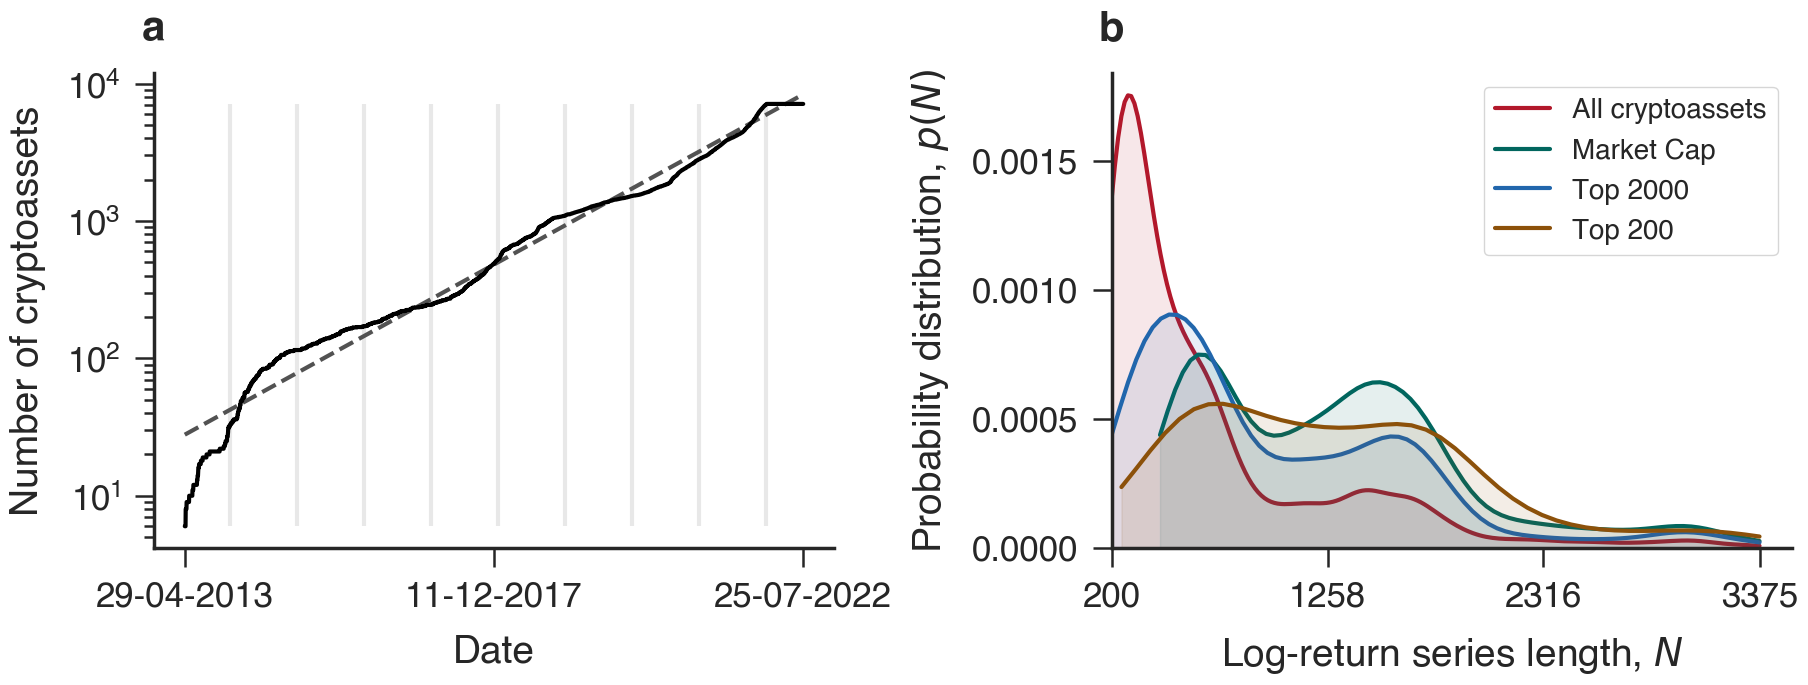

In [35]:
f, ax                       = plt.subplots(ncols=2, figsize=stdfigsize(ncols=2))
brown_, green_, red_, blue_ = ['#8c510a', '#01665e', '#b2182b', '#2166ac']

#PANEL A #####
series  = np.sum(count_series, axis=0)
tsdate  = pd.to_datetime(dates.values, format='%d-%m-%Y')

len_    = (tsdate - pd.to_datetime('29-04-2013', format='%d-%m-%Y')).days.values
k       = 10**scipy.stats.linregress(len_, np.log10(series)).intercept
b       = scipy.stats.linregress(len_, np.log10(series)).slope
exp_fit = k*10.**(b*len_)

ax[0].plot(tsdate, series, '-', color='#000000')
ax[0].plot(tsdate, exp_fit, '--', color='#525252', zorder=-2)
ax[0].vlines(pd.to_datetime(list(range(2014,2023,1)), format='%Y'), series.min(), series.max(), linestyle='-', color='#202020', alpha=.1, zorder=-10)
ax[0].set_yscale('log')
ax[0].set_ylabel('Number of cryptoassets')
ax[0].set_xlabel('Date')
ax[0].set_xticks(tsdate[[0, 1687, 3374]]) 
ax[0].set_xticklabels(dates.values[[0, 1687, 3374]]) 


#PANEL B #####
x, y, xmed, _, x25, x950 = KDE_function(all_goodness_clean.len.groupby('slug').apply(max).values, nbins=200, drange=True)
ax[1].plot(x, y, '-', color=red_, label='All cryptoassets', zorder=-2)
ax[1].fill_between(x, 0, y, color=red_, alpha=.1, zorder=-2)
ax[1].set_ylabel('PDF')
ax[1].set_xlabel('Number of days (returns) series')

x, y, xmed, _, x25, x950 = KDE_function(all_goodness_clean.loc[coin_positive_and_negative].len.groupby('slug').apply(max).values, nbins=80, drange=True)
ax[1].plot(x, y, '-', label='Market Cap', color=green_, zorder=-1)
ax[1].fill_between(x, 0, y, color=green_, alpha=.1, zorder=-1)
ax[1].set_ylabel('PDF')
ax[1].set_xlabel('Number of days (returns) series')
ax[1].legend(frameon=True)

x, y, xmed, _, x25, x950 = KDE_function(all_goodness_clean[all_goodness_clean['rank']<2000].len.groupby('slug', sort=False).apply(max).values, nbins=80, drange=True)
ax[1].plot(x, y, '-', label='Top 2000', color=blue_, zorder=0)
ax[1].fill_between(x, 0, y, color=blue_, alpha=.1, zorder=0)
ax[1].set_ylabel(r'Probability distribution, $p(N)$')
ax[1].set_xlabel('Log-return series length, $N$')

x, y, xmed, _, x25, x950 = KDE_function(all_goodness_clean[all_goodness_clean['rank']<200].len.groupby('slug', sort=False).apply(max).values, nbins=45, drange=True)
ax[1].plot(x, y, '-', label='Top 200', color=brown_, zorder=0)
ax[1].fill_between(x, 0, y, color=brown_, alpha=.1, zorder=0)
ax[1].set_ylabel(r'Probability distribution, $p(N)$')
ax[1].set_xlabel('Log-return series length, $N$')

cte = 1058
ax[1].set_xticks([200, 200+1058, 200+2*1058, 3375])
ax[1].set_ylim(0,)
ax[1].set_xlim(200,)
ax[1].legend(frameon=True)


###############
for i, ax_ in zip(range(2), ax):
    ax_.annotate(string.ascii_lowercase[i], (0.0, 1.07), xycoords='axes fraction', ha='center', weight='bold', fontsize=30)

f.tight_layout()
f.savefig('../final-figures/supplementary/figS1.pdf', dpi=300, bbox_inches='tight')

# <span style="font-family:calibri; font-weight:bold; font-size:1.4em;">Supplementary Figure S5</span><a class="anchor" id="s4"></a>

In [27]:
percentile_               = .9
all_goodness_clean['p90'] = all_goodness_clean.apply(powerlaw_percentile, percentile=percentile_, percentual=False, axis=1).values
pos_p90                   = all_goodness_clean[(all_goodness_clean.reject_powerlaw==False) & (all_goodness_clean.positive_tail==True)].p90.values
neg_p90                   = all_goodness_clean[(all_goodness_clean.reject_powerlaw==False) & (all_goodness_clean.positive_tail==False)].p90.values

df_                       = all_goodness_clean[all_goodness_clean['rank']<2000].copy(deep=True)
df_['p90']                = df_.apply(powerlaw_percentile, percentile=percentile_, percentual=False, axis=1).values
pos_p90_top2000           = df_[(df_.reject_powerlaw==False) & (df_.positive_tail==True)].p90.values
neg_p90_top2000           = df_[(df_.reject_powerlaw==False) & (df_.positive_tail==False)].p90.values

df_                       = all_goodness_clean[all_goodness_clean['rank']<200].copy(deep=True)
df_['p90']                = df_.apply(powerlaw_percentile, percentile=percentile_, percentual=False, axis=1).values
pos_p90_200top            = df_[(df_.reject_powerlaw==False) & (df_.positive_tail==True)].p90.values
neg_p90_200top            = df_[(df_.reject_powerlaw==False) & (df_.positive_tail==False)].p90.values

In [28]:
distro_x90_pos_200top = scipy_kde(pos_p90_200top, nbins=100, log=True).T
distro_x90_neg_200top = scipy_kde(neg_p90_200top, nbins=100, log=True).T

distro_x90_pos_top2000 = scipy_kde(pos_p90_top2000, nbins=250, log=True).T
distro_x90_neg_top2000 = scipy_kde(neg_p90_top2000, nbins=250, log=True).T

distro_x90_pos = scipy_kde(pos_p90, nbins=500, log=True).T
distro_x90_neg = scipy_kde(neg_p90, nbins=500, log=True).T

In [29]:
ratios_of_posneg_extrema_90_top2000                      = all_goodness_clean[all_goodness_clean['rank']<2000].groupby('slug', sort=False).apply(ratio_of_EXTREMA, percentile=.90)
nonans_ratios_of_posneg_extrema_90_top2000               = ratios_of_posneg_extrema_90_top2000.values[~np.isnan(ratios_of_posneg_extrema_90_top2000.values)]
x90_top2000, y90_top2000, xmed90_top2000, ymed90_top2000 = KDE_function(nonans_ratios_of_posneg_extrema_90_top2000, nbins=250)

ratios_of_posneg_extrema_90_200top                       = all_goodness_clean[all_goodness_clean['rank']<200].groupby('slug', sort=False).apply(ratio_of_EXTREMA, percentile=.90)
nonans_ratios_of_posneg_extrema_90_200top                = ratios_of_posneg_extrema_90_200top.values[~np.isnan(ratios_of_posneg_extrema_90_200top.values)]
x90_200top, y90_200top, xmed90_200top, ymed90_200top     = KDE_function(nonans_ratios_of_posneg_extrema_90_200top, nbins=100)

ratios_of_posneg_extrema_90                              = all_goodness_clean.groupby('slug', sort=False).apply(ratio_of_EXTREMA, percentile=.90)
nonans_ratios_of_posneg_extrema_90                       = ratios_of_posneg_extrema_90.values[~np.isnan(ratios_of_posneg_extrema_90.values)]
x90, y90, xmed90, ymed90                                 = KDE_function(nonans_ratios_of_posneg_extrema_90, nbins=500)

In [30]:
positive_extrema_ratio90_top2000 = sum(nonans_ratios_of_posneg_extrema_90_top2000)/len(nonans_ratios_of_posneg_extrema_90_top2000)
positive_extrema_ratio90_200top  = sum(nonans_ratios_of_posneg_extrema_90_200top>.5)/len(nonans_ratios_of_posneg_extrema_90_200top)
positive_extrema_ratio90         = sum(nonans_ratios_of_posneg_extrema_90>.5)/len(nonans_ratios_of_posneg_extrema_90)

In [31]:
pos_xmin            = all_goodness_clean[(all_goodness_clean['reject_powerlaw']==False) & (all_goodness_clean['positive_tail']==True) & (all_goodness_clean['rank']<2000)].xmin.values
neg_xmin            = all_goodness_clean[(all_goodness_clean['reject_powerlaw']==False) & (all_goodness_clean['positive_tail']==False) & (all_goodness_clean['rank']<2000)].xmin.values
pos_xmin_distro2000 = scipy_kde(pos_xmin, nbins=100, log=False).T
neg_xmin_distro2000 = scipy_kde(neg_xmin, nbins=100, log=False).T

maskmedian                     = np.abs(pos_xmin_distro2000[0] - np.median(pos_xmin)).argmin()
posxminmed2000, posyminmed2000 = np.median(pos_xmin), pos_xmin_distro2000[1][maskmedian]
maskmedian                     = np.abs(neg_xmin_distro2000[0] - np.median(neg_xmin)).argmin()
negxminmed2000, negyminmed2000 = np.median(neg_xmin), neg_xmin_distro2000[1][maskmedian]

In [32]:
pos_xmin           = all_goodness_clean[(all_goodness_clean['reject_powerlaw']==False) & (all_goodness_clean['positive_tail']==True) & (all_goodness_clean['rank']<200)].xmin.values
neg_xmin           = all_goodness_clean[(all_goodness_clean['reject_powerlaw']==False) & (all_goodness_clean['positive_tail']==False) & (all_goodness_clean['rank']<200)].xmin.values
pos_200xmin_distro = scipy_kde(pos_xmin, nbins=50, log=False).T
neg_200xmin_distro = scipy_kde(neg_xmin, nbins=50, log=False).T

maskmedian                   = np.abs(pos_200xmin_distro[0] - np.median(pos_xmin)).argmin()
posxminmed200, posyminmed200 = np.median(pos_xmin), pos_200xmin_distro[1][maskmedian]
maskmedian                   = np.abs(neg_200xmin_distro[0] - np.median(neg_xmin)).argmin()
negxminmed200, negyminmed200 = np.median(neg_xmin), neg_200xmin_distro[1][maskmedian]

In [33]:
pos_xmin        = all_goodness_clean[(all_goodness_clean['reject_powerlaw']==False) & (all_goodness_clean['positive_tail']==True)].xmin.values
neg_xmin        = all_goodness_clean[(all_goodness_clean['reject_powerlaw']==False) & (all_goodness_clean['positive_tail']==False)].xmin.values
pos_xmin_distro = scipy_kde(pos_xmin, nbins=500, log=False).T
neg_xmin_distro = scipy_kde(neg_xmin, nbins=500, log=False).T

maskmedian             = np.abs(pos_xmin_distro[0] - np.median(pos_xmin)).argmin()
posxminmed, posyminmed = np.median(pos_xmin), pos_xmin_distro[1][maskmedian]
maskmedian             = np.abs(neg_xmin_distro[0] - np.median(neg_xmin)).argmin()
negxminmed, negyminmed = np.median(neg_xmin), neg_xmin_distro[1][maskmedian]

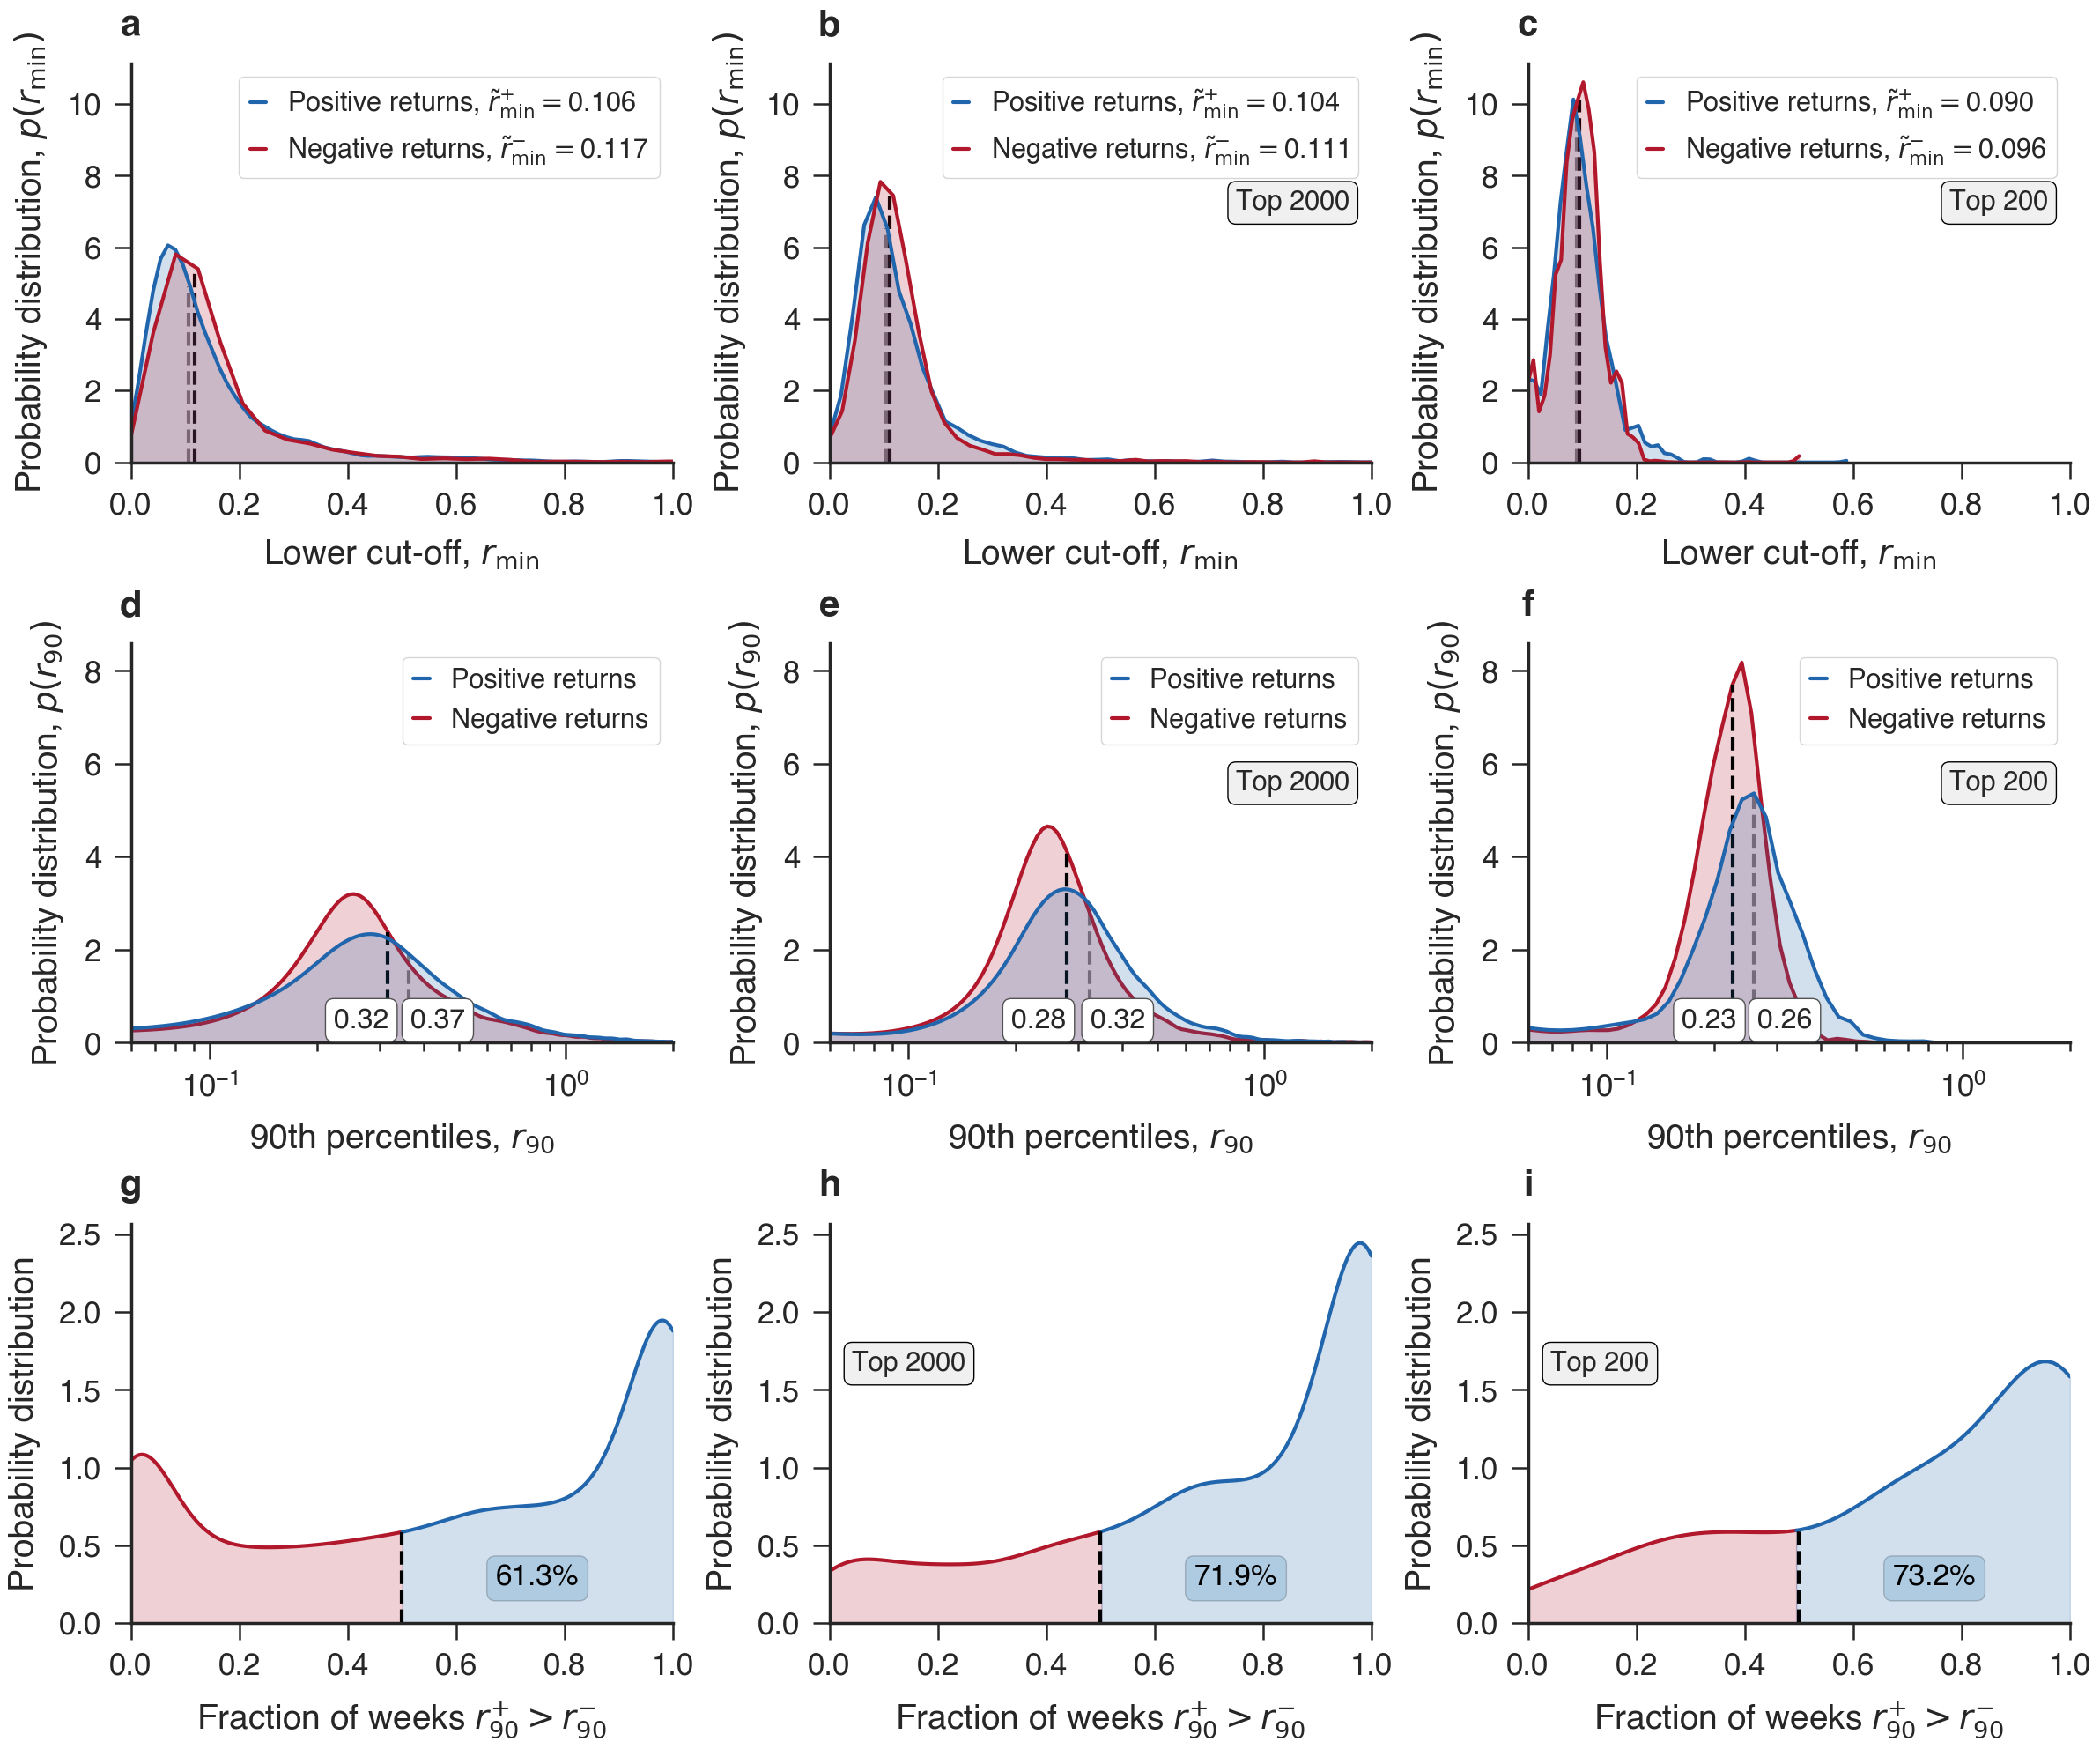

In [34]:
red, blue  = ['#b2182b', '#2166ac']
nc_        = 3
nr_        = 3
f, ax      = plt.subplots(ncols=nc_, nrows=nr_, figsize=stdfigsize(ncols=nc_, nrows=nr_, ratio=1.2, scale=.95))
ax, bx, cx = ax


######### Data formatting

distros_data     = [[distro_x90_pos, distro_x90_neg], [distro_x90_pos_top2000, distro_x90_neg_top2000], [distro_x90_pos_200top, distro_x90_neg_200top]]
emp_distros_data = [[pos_p90, neg_p90], [pos_p90_top2000, neg_p90_top2000], [pos_p90_200top, neg_p90_200top]]
fractions_data   = [[x90, y90], [x90_top2000, y90_top2000], [x90_200top, y90_200top]]
annotation       = ['', 'Top 2000', 'Top 200']
xmin_distro_data = [[pos_xmin_distro, neg_xmin_distro], [pos_xmin_distro2000, neg_xmin_distro2000], [pos_200xmin_distro, neg_200xmin_distro]]
xmin_med_data    = [[[posxminmed, posyminmed], [negxminmed, negyminmed]], [[posxminmed2000, posyminmed2000], [negxminmed2000, negyminmed2000]], [[posxminmed200, posyminmed200], [negxminmed200, negyminmed200]]]

percentiles      = ['90th percentile']*3
tails            = [['Positive returns', 'Negative returns']]*3

first_row_xlabel = ['90th percentiles, $r_{90}$']*3
first_row_ylabel = ['Probability distribution, $p(r_{90})$']*3
third_row_xlabel = [r'Lower cut-off, $r_{\rm min}$']*3
third_row_ylabel = [r'Probability distribution, $p(r_{\rm min})$']*3
sec_row_xlabel   = ['Fraction of weeks $r^{+}_{90} > r^{-}_{90}$']*3
sec_row_ylabel   = ['Probability distribution']*3
ratios           = [positive_extrema_ratio90, positive_extrema_ratio90_top2000, positive_extrema_ratio90_200top]



for ax_, bx_, cx_, (x_, y_), distros_, empdistros_, pct_, r_, fr_xl_, fr_yl_, sr_xl_, sr_yl_, (postail_, negtail_), (posxmin_, negxmin_), tr_xl_, tr_yl_, annotation_, xmin_meds in \
zip(ax, bx, cx, fractions_data, distros_data, emp_distros_data, percentiles, ratios, first_row_xlabel, first_row_ylabel, sec_row_xlabel, sec_row_ylabel, tails, xmin_distro_data, 
    third_row_xlabel, third_row_ylabel, annotation, xmin_med_data):    

############################################### First row
    medminx1, medminy1, medminx2, medminy2 = xmin_meds[0][0], xmin_meds[0][1], xmin_meds[1][0], xmin_meds[1][1]
    
    ax_.plot(*posxmin_, color=blue, label=postail_ + r', $\tilde{r}_{\rm min}^{+} = $' + f'{medminx1:.3f}')
    ax_.fill_between(*posxmin_, color=blue, alpha=.2)
    ax_.vlines(medminx1, 0, medminy1, linestyle='--', color='gray', zorder=-2)    
    
    ax_.plot(*negxmin_, color=red, label=negtail_+ r', $\tilde{r}_{\rm min}^{-} = $' + f'{medminx2:.3f}')
    ax_.fill_between(*negxmin_, color=red, alpha=.2)
    ax_.vlines(medminx2, 0, medminy2, linestyle='--', color='black', zorder=-2)    
    
    ax_.set_xlabel(tr_xl_)
    ax_.set_ylabel(tr_yl_)
    ax_.set_xlim(0,1)
    ax_.set_ylim(0,)
    ax_.annotate(annotation_, (.96, .65), va='center', ha='right', xycoords='axes fraction', fontsize=22, bbox={'boxstyle': 'round', 'fc': '#f0f0f0', 'ec': 'black', 'alpha': 1})
    ax_.legend(loc='upper right', handlelength=.6, fontsize=22)
    
############################################### Second row
    posdistro_, negdistro_   = distros_
    empposdist_, empnegdist_ = empdistros_
    
    bx_.semilogx(*posdistro_, color=blue, label=postail_)
    bx_.fill_between(*posdistro_, color=blue, alpha=.2)
    maskmedian = np.abs(posdistro_[0] - np.median(empposdist_)).argmin()
    bx_.vlines(posdistro_[0][maskmedian], 0, posdistro_[1][maskmedian], linestyle='--', color='gray', zorder=-2)
    bx_.annotate('{}'.format(round(np.median(empposdist_), 2)), (np.median(empposdist_), .2), va='bottom', ha='left', fontsize=23, bbox={'boxstyle': 'round', 'fc': 'white', 'ec': '#525252', 'alpha': 1 })
    
    bx_.semilogx(*negdistro_, color=red, zorder=-2, label=negtail_)
    bx_.fill_between(*negdistro_, color=red, alpha=.2, zorder=-2)
    maskmedian = np.abs(negdistro_[0]-np.median(empnegdist_)).argmin()
    bx_.vlines(negdistro_[0][maskmedian], 0, negdistro_[1][maskmedian], linestyle='--', color='black', zorder=-2)
    bx_.annotate('{}'.format(round(np.median(empnegdist_), 2)), (np.median(empnegdist_), .2), va='bottom', ha='right', fontsize=23, bbox={'boxstyle': 'round', 'fc': 'white', 'ec': '#525252', 'alpha': 1 })
    
    bx_.set_ylim(0,)
    bx_.set_ylabel(fr_yl_)
    bx_.set_xlabel(fr_xl_)    
    bx_.set_xlim(0.06, 2)
    bx_.legend(loc='upper right', handlelength=.6, fontsize=22)
    
    bx_.annotate(annotation_, (.96, .65), va='center', ha='right', xycoords='axes fraction', fontsize=22, bbox={'boxstyle': 'round', 'fc': '#f0f0f0', 'ec': 'black', 'alpha': 1})
    
################################################# Third row
    mask = np.abs(x_-.5).argmin() #selects the closest value to x = 0.5, which is our "equilibrium" value.
    cx_.plot(x_[x_<=x_[mask]], y_[x_<=x_[mask]], color=red)
    cx_.fill_between(x_[x_<=x_[mask]], y_[x_<=x_[mask]], color=red, alpha=.2)
    
    cx_.plot(x_[x_>x_[mask-1]], y_[x_>x_[mask-1]], color=blue)
    cx_.fill_between(x_[x_>x_[mask-1]], y_[x_>x_[mask-1]], color=blue, alpha=.2)
    
    cx_.vlines(.5, 0, y_[mask], linestyle='--', color='black')
    cx_.annotate(str(round(100*r_, 1))+'%', xy=(.75,.2), va='bottom', ha='center', fontsize=24, color='black',  bbox={'boxstyle': 'round', 'ec': 'black', 'alpha': .2})
    
    cx_.set_ylabel(sr_yl_)
    cx_.set_xlabel(sr_xl_)    
    cx_.set_ylim(0,)
    cx_.set_xlim(0,1)
    cx_.annotate(annotation_, (.042, .65), va='center', ha='left', xycoords='axes fraction', fontsize=22, bbox={'boxstyle': 'round', 'fc': '#f0f0f0', 'ec': 'black', 'alpha': 1})
    
ax[0].sharey(ax[2]), ax[1].sharey(ax[2])
bx[0].sharey(bx[2]), bx[1].sharey(bx[2])
cx[2].sharey(cx[1]), cx[0].sharey(cx[1])
for i, ax_, bx_, cx_ in zip(range(len(bx)), ax, bx, cx):
    ax_.annotate(string.ascii_lowercase[i], (0.0, 1.07), xycoords='axes fraction', ha='center', weight='bold', fontsize=30)
    bx_.annotate(string.ascii_lowercase[i+3], (0.0, 1.07), xycoords='axes fraction', ha='center', weight='bold', fontsize=30)
    cx_.annotate(string.ascii_lowercase[i+6], (0.0, 1.07), xycoords='axes fraction', ha='center', weight='bold', fontsize=30)
    
f.tight_layout()
f.savefig('../final-figures/supplementary/figS5.pdf', bbox_inches='tight', dpi=300)